# MalMem baseline experiments

Compare several classifiers on Obfuscated-MalMem2022 to decide which to integrate into the Flower client.

Run order:
1) Load data and inspect class balance.
2) Train/test split + standardization.
3) Evaluate multiple models with cross-validation.
4) Select the best trade-off (accuracy/F1 vs. model size/inference cost).

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

DATA_PATH = Path("Obfuscated-MalMem2022.csv")
if not DATA_PATH.exists():
    DATA_PATH = Path("..").joinpath("Obfuscated-MalMem2022.csv")
df = pd.read_csv(DATA_PATH)
print(df.head())
print("Class distribution:\n", df['Class'].value_counts())

# Features/labels
X = df.drop(columns=["Class", "Category"], errors="ignore").values.astype(float)
y = df["Class"].apply(lambda c: 0 if str(c).lower() == "benign" else 1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape", X_train.shape, "Test shape", X_test.shape)
print("Positive ratio (train)", y_train.mean())

  Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0   Benign            45            17           10.555556   
1   Benign            47            19           11.531915   
2   Benign            40            14           14.725000   
3   Benign            32            13           13.500000   
4   Benign            42            16           11.452381   

   pslist.nprocs64bit  pslist.avg_handlers  dlllist.ndlls  \
0                   0           202.844444           1694   
1                   0           242.234043           2074   
2                   0           288.225000           1932   
3                   0           264.281250           1445   
4                   0           281.333333           2067   

   dlllist.avg_dlls_per_proc  handles.nhandles  handles.avg_handles_per_proc  \
0                  38.500000              9129                    212.302326   
1                  44.127660             11385                    242.234043   
2                  4

In [10]:
# Define candidate models
models = {
    "logreg_l2": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    ),
    "mlp_2x128": make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(128, 128), alpha=1e-4, max_iter=50),
    ),
    "rf_200": RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight="balanced_subsample"),
    "gboost": GradientBoostingClassifier(),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc": "accuracy", "f1": "f1", "prec": "precision", "rec": "recall"}

cv_results = {}
for name, model in models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_results[name] = {metric: scores[f"test_{metric}"].mean() for metric in scoring}
    print(name, cv_results[name])

logreg_l2 {'acc': 0.9992106803185438, 'f1': 0.9992106574717207, 'prec': 0.9992748711477766, 'rec': 0.9991467121680693}
mlp_2x128 {'acc': 0.9999146666666668, 'f1': 0.9999146803156324, 'prec': 0.9998720500374771, 'rec': 0.999957337883959}
rf_200 {'acc': 0.9998933333333333, 'f1': 0.9998933606283542, 'prec': 0.9998294333859843, 'rec': 0.999957337883959}
gboost {'acc': 0.9998080022753129, 'f1': 0.9998080227463347, 'prec': 0.999786734895973, 'rec': 0.9998293424336138}


,acc,f1,prec,rec
mlp_2x128,0.999915,0.999915,0.999872,0.999957
rf_200,0.999893,0.999893,0.999829,0.999957
gboost,0.999808,0.999808,0.999787,0.999829
logreg_l2,0.999211,0.999211,0.999275,0.999147


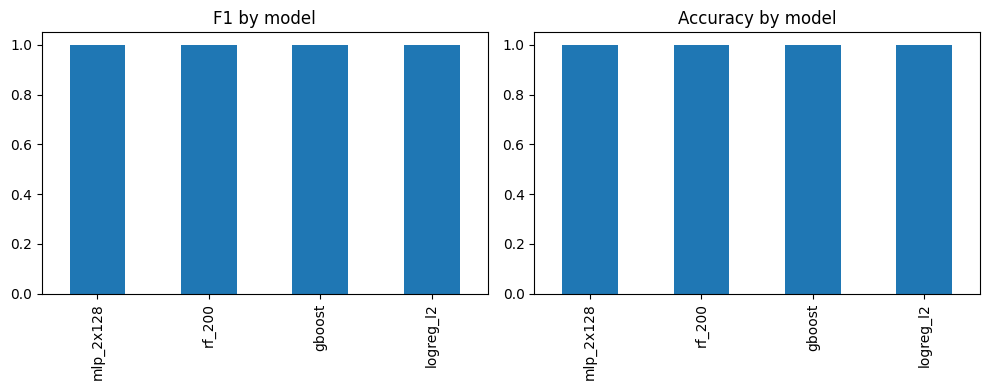

In [11]:
import matplotlib.pyplot as plt
cv_df = pd.DataFrame(cv_results).T.sort_values('f1', ascending=False)
display(cv_df)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cv_df['f1'].plot(kind='bar', ax=axes[0], title='F1 by model')
cv_df['acc'].plot(kind='bar', ax=axes[1], title='Accuracy by model')
plt.tight_layout()
plt.show()


In [12]:
# Fit the best model on full train and evaluate on holdout test
best_name = sorted(cv_results.items(), key=lambda kv: kv[1]["f1"], reverse=True)[0][0]
best_model = models[best_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("Selected model:", best_name)
print(classification_report(y_test, y_pred, target_names=["benign", "malware"]))


Selected model: mlp_2x128
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      5860
     malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

